<h1> BBHs merging catalog generator </h1> 

In the following, we'll implement a notebook that, given a certain volume of sky, will return a catalog of possible BBHs merging events.
The probability distribution implemented for the variables of the events, will be taken from [B. P. Abbott](https://arxiv.org/abs/1811.12940).
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
import multiprocessing as mp
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

Let's start by defining the probability distribution in function of the masses.
Even though the function is made in the regime $m_{min} \leq m_{2} \leq m_{1} \leq m_{max}$, in order to generate event with the standard convention, the fit of the parameters $\alpha$ and $\beta_q$ was made on the total number of events .
For this reason, even though the function was symmetrized, the total number of events should not be multiplied by 2.
We have :

In [2]:
# Function for estimating the Phase Space costant of the Mass distribution

def MassPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q):
    
    ris = 0.
    
    for i in range(len(ran_m1)- 1):
        for j in range(len(ran_m2)- 1):
            if(ran_m1[i] >= m_min and ran_m1[i] <= m_max and ran_m2[j] <= ran_m1[i] and ran_m2[j] >= m_min):
                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
                mid_m2 = 0.5*(ran_m2[j + 1] + ran_m2[j])
                q = mid_m2/mid_m1 
                ris +=  (ran_m1[i + 1] - ran_m1[i])*(ran_m2[j + 1] - ran_m2[j])*(np.power(mid_m1, (-alpha))*np.power(q, beta_q))
   
    return ris

In [3]:
# Function for the distribution in function of mass

def MassDistr(m1, m2, m_min, m_max, alpha, beta_q, C_norm):
    if(m1 >= m_min and m1 <= m_max and m2 <= m1 and m2 >= m_min) :
        q = m2/m1
        return (C_norm*np.power(m1, (-alpha))*np.power(q, beta_q))
    else :
        return 0.

Then, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [4]:
# Just a function to convert from Z to GPC using Hubble Law

def Z_to_Gpc(z):
    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 1

and the function that estimates the differential comoving volume in function of the redshift :

In [5]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z):
    r = Z_to_Gpc(z)    
    return ((4.*c*(10**(-3))*np.pi*(r**2.))/(H_0))

Now let's define the auxiliary functions for the spin distribution density :

In [6]:
def BetaSpinParameters(Expected_a, Var_a):
    expec_rel = (Expected_a/(1. - Expected_a))
    beta_a = ((expec_rel - Var_a*np.power(1. + expec_rel, 2.))/(Var_a*np.power(1. + expec_rel, 3.)))
    alpha_a = expec_rel*beta_a
    return alpha_a, beta_a

and hence, the spin distribution module density is given by :

In [7]:
# Estimating the beta function, that will be used as a normalization constant, by using the trapeze method to avoid problems in the extremes

def Beta_Func(span_a, alpha_a, beta_a):
    ris = 0.
    for i in range(len(span_a)- 1):
        mid_a = 0.5*(span_a[i + 1] + span_a[i])
        ris +=  (span_a[i + 1] - span_a[i])*(np.power(mid_a,(alpha_a - 1.))*np.power((1. - mid_a),(beta_a - 1.)))
   
    return ris

In [8]:
# Distribution for the spin amplitude, the beta distribution could get values bigger than 1 !

def SpinModDistrib(a, alpha_a, beta_a, Beta_Val):
     
    return ((np.power(a, alpha_a - 1.)*np.power(1. - a, beta_a - 1.))/(Beta_Val))

while the spin orientations distribution is given by :

In [9]:
# Spin orientation distribution, zeta = 1 gives a gaussian distribution centered in cos_ti = 1, zeta = 0 will return a isotropic distribution

def SpinOrientDistrib(cos_t1,cos_t2, zeta, sigma_1, sigma_2):
    prob = (1. - zeta)/(4) + ((2.*zeta)/(np.pi))*\
    (np.exp(-((np.power(1. - cos_t1,2.))/(2.*np.power(sigma_1,2.))))/(sigma_1*sc.erf(np.sqrt(2)/sigma_1)))\
    *(np.exp(-((np.power(1. - cos_t2,2.))/(2.*np.power(sigma_2,2.))))/(sigma_2*sc.erf(np.sqrt(2)/sigma_2)))
    return prob


We may finally define the distribution function for the number of events :

In [10]:
# Density function for the events in function of the parameters

def NDistrib(z,m1,m2,a_1,a_2,cos_t1,cos_t2):
    n = R_0*DeVC(z)*(T_tot /(1. + z)) \
    *MassDistr(m1,m2, m_min, m_max, alpha,beta_q, (1./MassPhaseSpace)) \
    *SpinModDistrib(a_1, alpha_a, beta_a, BetaVal)*SpinModDistrib(a_2, alpha_a, beta_a, BetaVal) \
    *SpinOrientDistrib(cos_t1, cos_t2, zeta, sigma_1, sigma_2)
    return n

a function to roughly estimate the initial orbital frequency of the event given the massess and the residual coalescence time, as taken by **equation 11 a)** of [S. Marsat and J. G. Baker](https://arxiv.org/pdf/1806.10734.pdf); from that equation we may also estimate the residual time for the events frequency to go outside of the LISA band :

In [11]:
#This function given the mass of the two events and the residual time to coalescence, return the initial frequency of the event at the LISA detection time
def GetInitialFrequency(m1,m2,coal_T):
    M = m1 + m2
    ni = (m1*m2)/(M*M)
    res = ((256.*ni)/(5.*np.power((c*(10.**3.)),5.)))*np.power((G*M*sol_mass),(5./3.))*coal_T
    return (np.power(res,(-(3./8.)))/np.pi)

In [12]:
#This function given the mass of the two events and the max frequency detectable, return the residual time that the event will spend on the Lisa band
def TimeOutFrqRange(m1,m2,f_max):
    M = m1 + m2
    ni = (m1*m2)/(M*M)
    res = (5.*np.power((c*(10.**3.)),5.))/(256.*ni*np.power((np.pi*f_max),(8./3.))*np.power((G*M*sol_mass),(5./3.)))
    return res/year

and some other functions just to make the result appear sexier :

In [13]:
# This function will generate a fake name for the event in the time range of the LISA mission, it will not generate events in the day 29,30,31

def Gen_Event_name():
    
    month = random.randrange(12) + 1
    day = random.randrange(28) + 1
    nid = str(random.randrange(1000) + 1)
    
    if month < 10 :
        month = '0'+ str(month)        
    else:
        month = str(month)
        
    if day < 10 :
        day = '0'+ str(day)        
    else:
        day = str(day)    
        
    return "GW"+ str(random.randrange(34,37))+ month + day +"NId"+ nid


In [14]:
# Generate a number of events equal to the lenght of the array N_EvXBin, with random values in the phase deltavolume for each of the parameter

def Gen_Events_Parameters(idx_m1, idx_m2, idx_z, idx_a1, idx_a2, idx_ct1, idx_ct2) :
                                
        ev_m1 = random.uniform(ran_m1[idx_m1],ran_m1[idx_m1 + 1])
        ev_m2 = random.uniform(ran_m2[idx_m2],ran_m2[idx_m2 + 1])
        # By convention we impose that m1 is the biggest mass among the 2
        if(ev_m2 > ev_m1):
            app = ev_m1
            ev_m1 = ev_m2
            ev_m2 = app
        ev_ttilde = random.uniform(0., max_tc)                            
        ev_ifrq = GetInitialFrequency(ev_m1,ev_m2,ev_ttilde*year)
        
        # If the event frequency is within the LISA band the others parameters would be generated, in the other case the event is rejected 
        
        if(ev_ifrq <= frq_max):
            ev_ttmaxfr = ev_ttilde -TimeOutFrqRange(ev_m1, ev_m2, frq_max)
            ev_z = random.uniform(ran_z[idx_z],ran_z[idx_z + 1])
            
            #ev_nm = Gen_Event_name()
            
            ev_sa1 = random.uniform(ran_a_1[idx_a1],ran_a_1[idx_a1 + 1])
            ev_sa2 = random.uniform(ran_a_2[idx_a2],ran_a_2[idx_a2 + 1])
            
            # As we imposed the simmetry of the spin amplitude distribution, and we run the simulation over sa1 > sa2 by doubling the generated events, let's give a chance to invert the spin among the 2 
            
            if(np.random.random() >= 0.5):
                app = ev_sa1
                ev_sa1 = ev_sa2
                ev_sa2 = app
            
            ev_st1 = np.arccos(random.uniform(ran_cos_t1[idx_ct1],ran_cos_t1[idx_ct1 + 1]))
            ev_st2 = np.arccos(random.uniform(ran_cos_t2[idx_ct2],ran_cos_t2[idx_ct2 + 1]))
            
            # As we imposed the simmetry of the spin tilt distribution, and we run the simulation over st1 > st2 by doubling the generated events, let's give a chance to invert the tilt among the 2 
            
            if(np.random.random() >= 0.5):
                app = ev_st1
                ev_st1 = ev_st2
                ev_st2 = app
            
            # Appending the generated event to the catalogue
            
            BH = pd.DataFrame([[ev_z, ev_m1, ev_m2, ev_ifrq, ev_ttmaxfr, ev_ttilde, ev_sa1, ev_sa2, ev_st1, ev_st2],],\
                                columns = ['Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'InBandTime',  'CoalTime', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])
            return BH
        else:
            BH = pd.DataFrame({'none' : []})
            return BH

In [15]:
# This function, will parallelize the nested cycles splitting that in function of the mass_1 bin, each process will then estimate the number of events for the given mass_1 bin and generate the events to append to the dataframe

def init_globals(Nr,Ne,Prc):
    global Nreal,Nev,Perc
    Nreal = Nr
    Nev = Ne
    Perc = Prc

def  Bin_and_Gen(d,im1) :
    # Let's use the fact that the mass probability distribution gives 0 for m2 > m1 
    for im2 in (range(im1 + 1)):
        for iz in range(len(ran_z) - 1):
            for ia_1 in range(len(ran_a_1)-1):
                # Let's use the symmetry of the spin amplitude distribution to just run over s_a1 > s_a2, the number of events outside the diagonal should be multiplied by 2
                for ia_2 in range(ia_1 + 1):
                    for ict1 in range(len(ran_cos_t1)-1):
                        # Let's use the symmetry of the spin tilt distribution to just run over s_t1 > s_t2, the number of events outside the diagonal should be multiplied by 2
                        for ict2 in range(ict1+1):
                            # estimating the value of NDistrib in function of the values, the value will be interpolated with the trapeze method
                            
                            nstep =  NDistrib(st.mean([ran_z[iz],ran_z[iz + 1]]),st.mean([ran_m1[im1],ran_m1[im1 + 1]]),st.mean([ran_m2[im2],ran_m2[im2 + 1]]),st.mean([ran_a_1[ia_1],ran_a_1[ia_1 + 1]])\
                                     ,st.mean([ran_a_2[ia_2],ran_a_2[ia_2 + 1]]),st.mean([ran_cos_t1[ict1],ran_cos_t1[ict1 + 1]]),st.mean([ran_cos_t2[ict2],ran_cos_t2[ict2 + 1]]))
                            # to obtain the real result of the integral, we now need to multiply for the 4 factor due to the used simmetries of spin amplitude and spin tilt distribution, time the values of the delta of all the integration variables  
                            
                            nstep *= 4.*(ran_z[iz +1] - ran_z[iz])*(ran_m1[im1 + 1] - ran_m1[im1])*(ran_m2[im2 + 1] - ran_m2[im2])*(ran_a_1[ia_1 + 1] - ran_a_1[ia_1])*(ran_a_2[ia_2 + 1] - ran_a_2[ia_2])\
                                     *(ran_cos_t1[ict1+1]-ran_cos_t1[ict1])*(ran_cos_t2[ict2+1]-ran_cos_t2[ict2])
                            
                            # If we are on the diagonal bin for ia or ict, we don't need to multiply the events by 2 !
                            
                            if(ia_1 == ia_2) : nstep = nstep / 2.
                            if(ict1 == ict2) : nstep = nstep / 2.     
                            
                            # Addint the fraction of events to the cumulative sum
                            
                            with Nreal.get_lock():            
                                Nreal.value += nstep 
                            
                            # Checking if mode_fast_mc and implementing
                                                        
                            if(mode_fastmc):
                                if(nstep >=1.):
                                    if(nstep - round(nstep) >= 0):
                                        res = nstep - round(nstep)
                                        if(np.random.random() <= res):
                                            nstep = round(nstep) + 1.
                                    else:
                                        res = nstep + 1. - round(nstep)
                                        if(np.random.random() >= res):
                                            nstep = round(nstep) - 1.
                                else:
                                        if(np.random.random() <= nstep):
                                            nstep = 1.
                            
                            # Checking if mode exotic
                                        
                            if(mode_ex):
                                nstep += (np.random.random()*0.5)
                                
                            # The value need to be round up to an integer
                            nstep = round(nstep)
                            with Nev.get_lock():
                                Nev.value += int(nstep)
                            
                            # The estimated number of events will now be generated
                            
                            for i in range(int(nstep)):
                                delta_BH = Gen_Events_Parameters(im1, im2, iz, ia_1, ia_2, ict1, ict2)
                                if(not delta_BH.empty):
                                    d.append(delta_BH)

    # Increase the percentage index and print percentage
    
    with Perc.get_lock():
         Perc.value += 1
         print('Percentage of completition : ',(Perc.value*100.)/(len(ran_m1)-1), '%')

The global variables of the simulation will be set to :

In [16]:
# Flags for the execution modes

mode_ex = False
mode_fastmc = False

# Flag for the random seed selection

sel_rs = False

# Number of jobs spawned by the multiprocessing part of the program (use 9/10 * number of core to avoid problems)

n_jobs = (mp.cpu_count() - 8)

# To avoid to saturate the ram when copying the generated list to a dataframe, the process will be made by slicing the list in percentage

cp_perc = 0.1 # If ram > 16 GB put cp_perc = 1 to do the copy in one single step

# Mass Distribution parameters (values taken from the results of arxiv 1811.12940)

m_min = 5. # Solar Masses
m_max = 50. # Solar Masses
alpha = 1.6 # +-1.6 Big Error !
beta_q = 6.7 # +4.8 -5.9 Still Big Error !

#Spin Amplitude Distribution parameter (values assumed considering the results of  arxiv 1811.12940)

Expected_a = 0.2 # Expected value for the spin amplitude a, < 0.5 with 90% confidence 
Var_a = 1./40.  # Need to setup this value to obtain alpha_a and beta_a >=1
a_max = 1.
alpha_a, beta_a = BetaSpinParameters(Expected_a, Var_a)

#Spin tilt Distribution parameters

sigma_1 = 5.
sigma_2 = 5.
zeta = 1. # For a gaussian distribution of the spin alignment 

# Merger distribution parameters

T_obs = 3. # Lisa estimated years of observation
max_tc = 1000. # max years of coalescence time for a BBH mergine event 
R_0 = 53.2 # +58.5 - 27.0 Gpc^-3 yr-1 Merger rate density assumed constant over the comoving volume
zmax = 0.5 # z value corrispondent to 2 gigaparsec
frq_max = 0.5 # Maximum frequency in hertz to which the LISA detector is sensitive 

#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
H_0 = 67.8 # Hubble constant in Km/(s*MPc)
year = 365.25*24*60*60 # Years in second 

if(alpha_a <=1 or beta_a <=1):
    print('Error in the selection of the values for E[a] and Var[a]')
    
# Precision settings for the binned variables

mass_prec = 50            # Binning density for the masses
z_prec = 20             # Binning density for the redshift (affect distance density)
spin_ampl_prec = 16       # Binning density for the spin amplitudes
spin_tilt_prec = 12      # Binning density for the spin tilt s (setted low as not really needed) 

Let's plot the colormaps of the probability functions to check how they behave :

The integrated probability for all possible mass pairs is :  0.9999999999999982


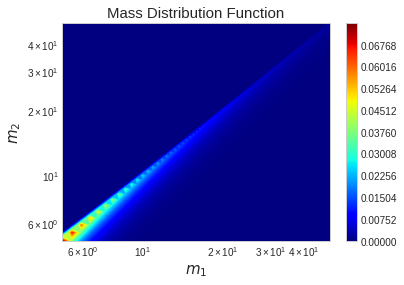

In [17]:
# Colormap of the mass distribution function

Z = np.zeros((100,100))
ran_m1 = np.linspace(m_min,m_max,100)
ran_m2 = np.linspace(m_min,m_max,100)
MassPhaseSpace = MassPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q)
X, Y = np.meshgrid(ran_m1, ran_m2)

for i in range(len(ran_m1)):
    for j in range(len(ran_m2)):
        Z[j][i] = MassDistr(X[j][i], Y[j][i], m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))
        
plt.contourf(X, Y, Z, 1000, cmap='jet')
plt.colorbar();
plt.xlabel(r'$m_1$', fontsize = 15)
plt.ylabel(r'$m_2$', fontsize = 15)
plt.title('Mass Distribution Function', fontsize = 15)
plt.loglog()
plt.savefig('MassDistrib.png',dpi=500)

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_m1)-1):
    for j in range(len(ran_m2)-1):
        totprob += (ran_m1[i + 1] - ran_m1[i])*(ran_m2[j + 1] - ran_m2[j])*MassDistr(st.mean([ran_m1[i],ran_m1[i+1]]), st.mean([ran_m2[j],ran_m2[j+1]]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))

print('The integrated probability for all possible mass pairs is : ', totprob) 

The integrated probability for all possible spin amplitudes is :  1.0000000000000007


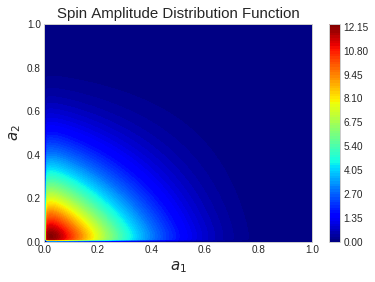

In [18]:
# Colormap of the spin amplitude distribution function, it may be observed the symmetry for swaps among a_1 and a_2

Z = np.zeros((100,100))
ran_a1 = np.linspace(0.,a_max,100)
ran_a2 = np.linspace(0.,a_max,100)
BetaVal = Beta_Func(ran_a1, alpha_a, beta_a)
X, Y = np.meshgrid(ran_a1, ran_a2)

for i in range(len(ran_a1)):
    for j in range(len(ran_a2)):
        Z[j][i] = SpinModDistrib(X[j][i], alpha_a, beta_a, BetaVal)*SpinModDistrib(Y[j][i], alpha_a, beta_a, BetaVal)
        
plt.contourf(X, Y, Z, 100, cmap='jet')
plt.colorbar();
plt.xlabel(r'$a_1$', fontsize = 15)
plt.ylabel(r'$a_2$', fontsize = 15)
plt.title('Spin Amplitude Distribution Function', fontsize = 15)
plt.savefig('SpinAmpDistrib.png',dpi=500)

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_a1)-1):
    for j in range(len(ran_a2)-1):
        totprob += (ran_a1[i + 1] - ran_a1[i])*(ran_a2[j + 1] - ran_a2[j])*SpinModDistrib(st.mean([ran_a1[i],ran_a1[i+1]]), alpha_a, beta_a, BetaVal)*SpinModDistrib(st.mean([ran_a2[j],ran_a2[j+1]]), alpha_a, beta_a, BetaVal)

print('The integrated probability for all possible spin amplitudes is : ', totprob)        

The integrated probability for all possible tilt angles is :  1.0000012893885282


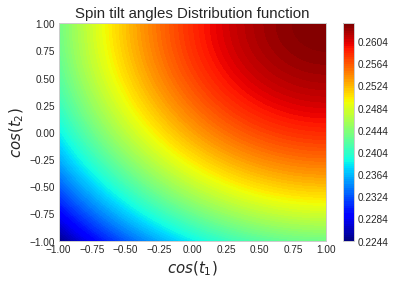

In [19]:
# Colormap of the spin tilt distribution function, it may be observed the symmetry for swap between cos(t1) and cos(t2)

Z = np.zeros((100,100))
ran_cos_t1 = np.linspace(-1.,1.,100)
ran_cos_t2 = np.linspace(-1.,1.,100)
X, Y = np.meshgrid(ran_cos_t1, ran_cos_t2)

for i in range(len(ran_cos_t1)):
    for j in range(len(ran_cos_t2)):
        Z[j][i] = SpinOrientDistrib(X[j][i], Y[j][i], zeta, sigma_1, sigma_2)
        
plt.contourf(X, Y, Z, 100, cmap='jet')
plt.colorbar();
plt.xlabel(r'$cos(t_1)$', fontsize = 15)
plt.ylabel(r'$cos(t_2)$', fontsize = 15)
plt.title('Spin tilt angles Distribution function', fontsize = 15)
plt.savefig('SpinTiltDistrib.png',dpi=500)

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_cos_t1)-1):
    for j in range(len(ran_cos_t2)-1):
        totprob += (ran_cos_t1[i + 1] - ran_cos_t1[i])*(ran_cos_t2[j + 1] - ran_cos_t2[j])*SpinOrientDistrib(st.mean([ran_cos_t1[i],ran_cos_t1[i + 1]]), st.mean([ran_cos_t2[j],ran_cos_t2[j + 1]]), zeta, sigma_1, sigma_2)

print('The integrated probability for all possible tilt angles is : ', totprob)


Let's reset the predefined array to avoid RAM consumption :  

In [20]:
X, Y, Z = np.zeros(1),np.zeros(1),np.zeros(1)

The simulation will be spanned over the following range of variables :

In [21]:
ran_m1 = np.linspace(m_min,m_max,mass_prec)
ran_m2 = np.linspace(m_min,m_max,mass_prec)
MassPhaseSpace = MassPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q)
ran_z = np.linspace(0.,zmax, z_prec)    # Don't put bins too small or the volume wouldn't be enough to generate events
ran_a_1 = np.linspace(0., a_max,spin_ampl_prec)
ran_a_2 = np.linspace(0., a_max,spin_ampl_prec)
BetaVal = Beta_Func(ran_a_1, alpha_a, beta_a)
ran_cos_t1 = np.linspace(-1.,1.,spin_tilt_prec)
ran_cos_t2 = np.linspace(-1.,1.,spin_tilt_prec)

and the result will be saved in the BHCat dataframe :

In [22]:
BHCat = pd.DataFrame(columns=['Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'InBandTime', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])

# The Lisa Dataframe instead will be saved without the EventName and will have the following variables and unit of measure 

SOBBHsunits = {

'Redshift': 'Unit',\
    
'Mass1': 'SolarMass',\
    
'Mass2': 'SolarMass',\

'InitialFrequency' : 'Hertz',\
    
'InBandTime' : 'Years',\

'EclipticLongitude' : 'Radian',\
    
'EclipticLatitude' : 'Radian',\
    
'Inclination' : 'Radian',\

'Polarization' : 'Radian',\
    
'InitialPhase' : 'Radian',\
    
'CoalTime' : 'Years',\
    
'Distance' : 'GigaParsec',\

'Spin1' : 'Unit',\
    
'Spin2' : 'Unit',\
    
'AzimuthalAngleOfSpin1' : 'Radian',\
    
'AzimuthalAngleOfSpin2' : 'Radian'    

}

In [23]:
# Example of the format of an added merging event
#BH= pd.DataFrame([[0.2,2 4.6, 18.3, 0.2, 128.5, -0.9, 4.25, 2.4, 1.6, 5.2, 251., 0.8, 0.2, 0.15, -0.2,0.4],], columns=['EventName', 'Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])

The standard way of simulating the events will generate the same number of events in the same range of variables every time it was run...
To give to the simulation a little bit of randomness, and allow the generation of merging events with exotic range of variable, set the **exotic_mode** flags to true. 

In [24]:
#mode_ex = True # If true, in each volume of the phase space it will randomly add a number between [0,0.5]

In alternative, the events may be simulated using a fast Monte Carlo method, to do so set the **mode_fastmc** flag to true.\
**Beware, only one flag may be setup at a single time !**

In [25]:
mode_fastmc = True # If True, on each bin will generate a random uniform value and if the value is within the probability range a new event will be added

Furthermore, you may choose to manually set up the random seeds for the simulation, in order to make that more reproducible :

In [26]:
#sel_rs = True # Uncomment this to manually select the random seed of the simulation

if(sel_rs):
    np_seed = 0 # Change this value to the desired seed for numpy
    rd_seed = 0 # Change this value to the desired seed for random
    np.random.seed(np_seed)
    random.seed(rd_seed)
    

We may finally launch the pipeline to generate the merging events in the considered volume :

In [27]:
# The total time used to generate the merging events by multipling for the rate of merging will be set to max_tc
T_tot = max_tc

# Checking if flags variable are correct

if(mode_fastmc and mode_ex):
    print('!! WARNING !! The simulation is not able to run with both mode flags on, it will be setted by default to mode_fastmc !')
    mode_ex = False
    

if __name__ == '__main__':                                    
    # start the worker processes equals to n_jobs
    print('Percentage of completition : ',0., ' %')
    Nev = Value('i', 0)
    Perc = Value('i', 0)
    Nreal = Value('d', 0.)
    with Pool(processes = n_jobs, initializer = init_globals, initargs = (Nreal,Nev, Perc)) as pool:
        manager = Manager()
        d = manager.list() 
        par_func = partial(Bin_and_Gen, d)
        pool.map(par_func, range(len(ran_m1)-1))
        pool.close()
        pool.join()
                                                       
print('During the simulation, ', Nev.value, ' merging events where generated over the ',int(round(Nreal.value)), ' predicted !')
print('Among the ', Nev.value, ' merging events generated ',Nev.value - len(d),' of the generated events were rejected as outisde of the Lisa band')

Percentage of completition :  0.0  %
Percentage of completition :  2.0408163265306123 %
Percentage of completition :  4.081632653061225 %
Percentage of completition :  6.122448979591836 %
Percentage of completition :  8.16326530612245 %
Percentage of completition :  10.204081632653061 %
Percentage of completition :  12.244897959183673 %
Percentage of completition :  14.285714285714286 %
Percentage of completition :  16.3265306122449 %
Percentage of completition :  18.367346938775512 %
Percentage of completition :  20.408163265306122 %
Percentage of completition :  22.448979591836736 %
Percentage of completition :  24.489795918367346 %
Percentage of completition :  26.53061224489796 %
Percentage of completition :  28.571428571428573 %
Percentage of completition :  30.612244897959183 %
Percentage of completition :  32.6530612244898 %
Percentage of completition :  34.69387755102041 %
Percentage of completition :  36.734693877551024 %
Percentage of completition :  38.775510204081634 %
Perc

We may now save the generated list to a dataframe and reset the value of said list:


In [28]:
print ('The generated list will now be copied to a dataframe !')
Perc.value = 0
while (len(d) > 0):
    slc_end = int((cp_perc*Nev.value)+1)
    delta_BH = pd.concat(d[0:slc_end], ignore_index=True)
    del d[0:slc_end]
    BHCat = BHCat.append(delta_BH, sort= False, ignore_index = True)
    Perc.value += 1
    print('Percentage of copying : ',(Perc.value*cp_perc*100),'%')

The generated list will now be copied to a dataframe !
Percentage of copying :  10.0 %
Percentage of copying :  20.0 %
Percentage of copying :  30.000000000000004 %
Percentage of copying :  40.0 %
Percentage of copying :  50.0 %
Percentage of copying :  60.00000000000001 %
Percentage of copying :  70.0 %
Percentage of copying :  80.0 %
Percentage of copying :  90.0 %
Percentage of copying :  100.0 %


and add to the generated dataframe all the missing uniform variables by using fast vectorized operations :


In [29]:
BHCat['Distance'] = Z_to_Gpc(BHCat.Redshift)                                # Estimate the distance from the redshift using Hubble Law
BHCat['InitialPhase'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi           # Random value between 0 and 2pi
BHCat['EclipticLongitude'] = (np.random.rand(len(BHCat.Mass1))-0.5)*np.pi   # Random value between -pi/2 and pi/2
BHCat['EclipticLatitude'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi       # Random value between 0 and 2pi
BHCat['Inclination'] = np.random.rand(len(BHCat.Mass1))*np.pi               # Random value between 0 and pi
BHCat['Polarization'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi           # Random value between 0 and 2pi

and we may finally save the complete dataframe :

In [30]:
# Saving the Dataframe

df_key = 'SOBBH'

if(mode_ex):
    df_nm = 'SOBBHCatalogueExotic.h5'        
else:
    if(mode_fastmc):
        df_nm = 'SOBBHCatalogueMC.h5'       
    else:
        df_nm = 'SOBBHCatalogue.h5'
        
BHCat.to_hdf(df_nm, df_key, mode='w')     

Let's load the dataframe and sort by frequency to see over which values the frequencies spanned :

In [31]:
BHCat = pd.read_hdf(df_nm, df_key)
BHCat.sort_values(by=['InitialFrequency'])

,Redshift,Mass1,Mass2,InitialFrequency,InBandTime,EclipticLongitude,EclipticLatitude,Inclination,Polarization,InitialPhase,CoalTime,Distance,Spin1,Spin2,AzimuthalAngleOfSpin1,AzimuthalAngleOfSpin2
1811146,0.243646,49.993938,49.731601,0.001656,996.154070,-0.996408,1.234208,0.920189,0.039261,0.348608,996.154313,1.077335,0.030864,0.260799,1.607891,1.807210
1812430,0.361554,49.874657,49.736088,0.001657,996.823588,1.100630,3.307607,1.672852,1.467263,3.959693,996.823832,1.598690,0.310412,0.014524,1.431322,1.790324
1813424,0.455182,49.988938,49.819051,0.001658,992.740238,0.440575,4.642385,0.039496,1.846321,4.934511,992.740480,2.012687,0.011110,0.104430,1.198032,1.176371
1812959,0.419375,49.881582,49.474478,0.001658,999.314885,0.777572,4.500978,2.523310,6.178270,4.252874,999.315130,1.854360,0.101852,0.294714,1.239319,0.578762
1813302,0.432245,49.947693,49.366618,0.001660,997.362002,0.326128,4.430323,0.756907,3.287238,0.551662,997.362247,1.911263,0.164950,0.419659,1.883201,1.733113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611274,0.480709,11.883581,7.365430,0.397844,0.003348,-0.878735,4.575810,0.242484,0.796455,5.135843,0.007335,2.125560,0.262464,0.503331,2.500157,2.063253
850193,0.342383,17.688136,10.546013,0.431976,0.001014,1.357543,3.573550,1.609530,0.774469,0.365426,0.003140,1.513920,0.176023,0.351065,1.600840,0.986472
37571,0.173710,7.651795,6.622604,0.448971,0.002073,1.041071,0.692353,0.064787,3.404376,3.076470,0.008308,0.768095,0.131893,0.171264,2.728945,1.630372
183342,0.378674,10.588322,9.495034,0.451986,0.001088,0.648694,5.251837,2.406747,1.374885,5.118747,0.004609,1.674388,0.141212,0.021424,0.822926,1.997826


To check that the generated dataframe is following the density distributions, let's plot a scatter plot of the masses :

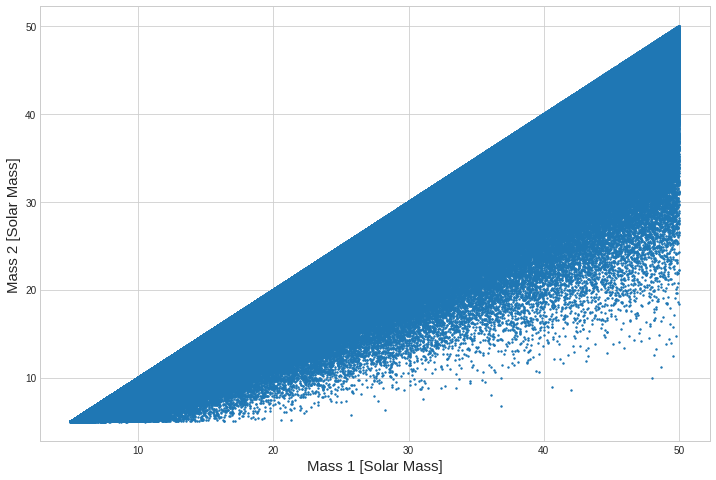

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['Mass1'], BHCat['Mass2'], s=2)
plt.xlabel('Mass 1 [Solar Mass]', fontsize = 15)
plt.ylabel('Mass 2 [Solar Mass]', fontsize = 15)
plt.savefig('MassesScatterplot.png',dpi=500)

Together with a scatter plot for the spin amplitude and orientation :


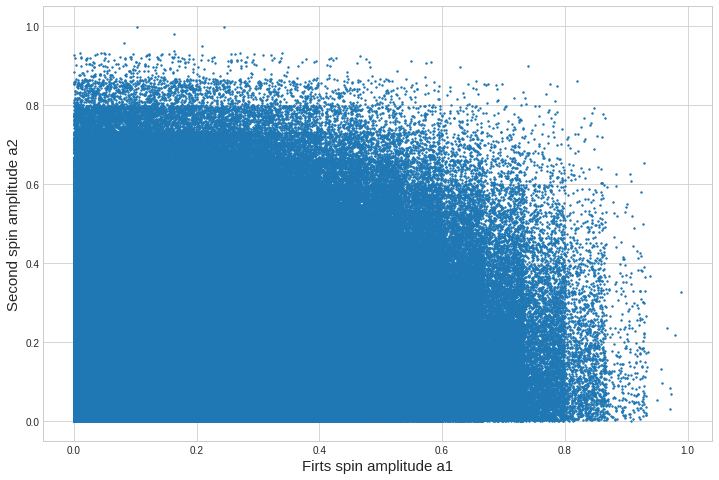

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['Spin1'], BHCat['Spin2'], s=2)
plt.xlabel('Firts spin amplitude a1', fontsize = 15)
plt.ylabel('Second spin amplitude a2', fontsize = 15)
plt.savefig('FrqHist.png',dpi=500)
plt.savefig('SpinAmplitudesScatterplot.png',dpi=500)

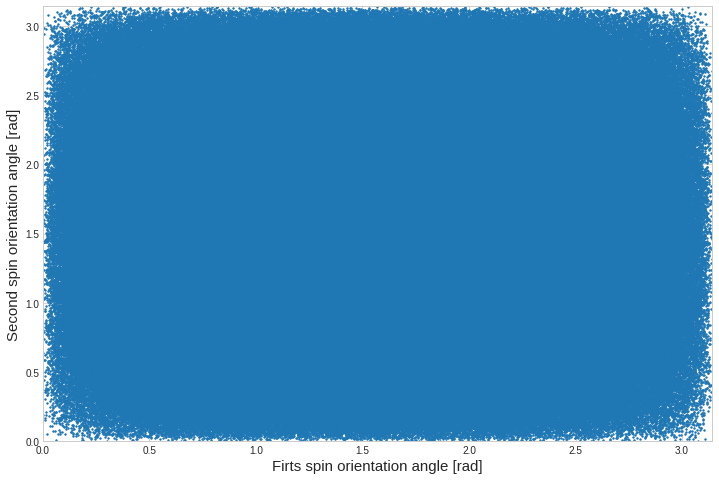

In [34]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['AzimuthalAngleOfSpin1'], BHCat['AzimuthalAngleOfSpin2'], s=2)
plt.xlabel('Firts spin orientation angle [rad]', fontsize = 15)
plt.ylabel('Second spin orientation angle [rad]', fontsize = 15)
plt.xlim(0,np.pi)
plt.ylim(0,np.pi)
plt.savefig('SpinTiltsScatterplot.png',dpi=500)

Finally, the properties of the generated dataframe may be observed from an histogram of the frequencies :

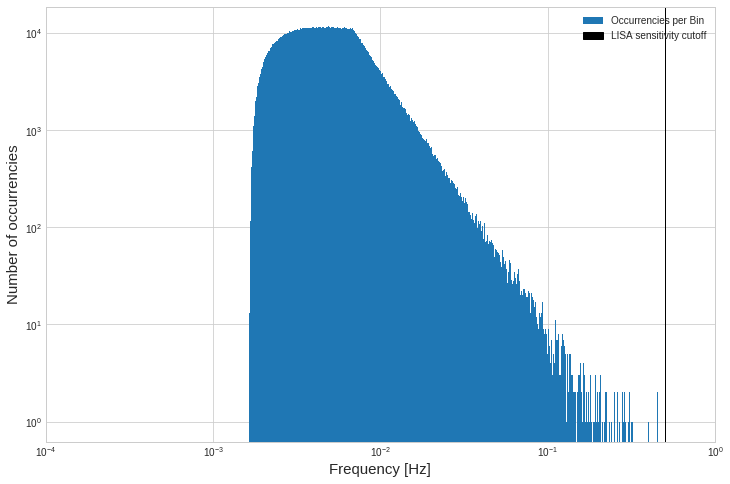

In [35]:
plt.figure(figsize=(12,8))
plt.xscale('log')
plt.yscale('log')
log_bin = np.logspace(-4,0,1000)
plt.hist(BHCat['InitialFrequency'], bins = log_bin, label = 'Occurrencies per Bin')
plt.xlabel('Frequency [Hz]', fontsize = 15)
plt.xlim(10**(-4),1)
plt.axvspan(frq_max-0.001, frq_max + 0.001, 0, 1, color = 'black', label = 'LISA sensitivity cutoff')
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('FrqHist.png',dpi=500)

and an hystogram showing the time of each event inside the LISA band :

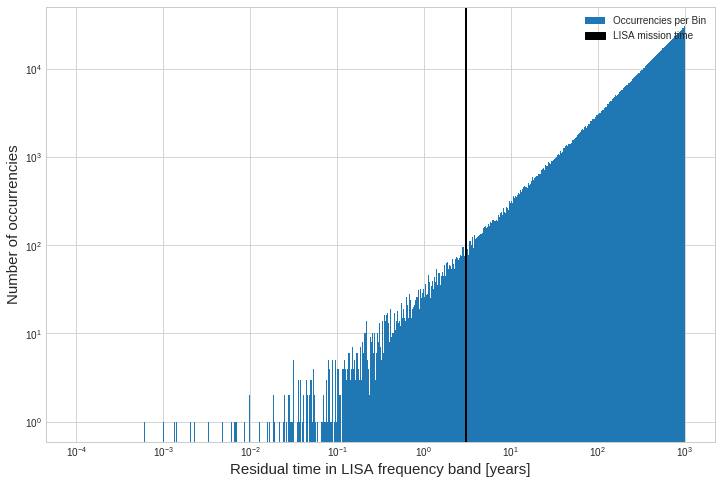

In [36]:
plt.figure(figsize=(12,8))
plt.xscale('log')
plt.yscale('log')
log_bin = np.logspace(-4,3,1000)
plt.hist(BHCat['InBandTime'], bins = log_bin, label = 'Occurrencies per Bin')
plt.xlabel('Residual time in LISA frequency band [years]', fontsize = 15 )
plt.axvspan(T_obs - 0.01, T_obs + 0.01, 0, 1, color = 'black', label = 'LISA mission time')
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('TimeInFrequencyBand.png',dpi=500)

Lastly, let's convert the dataframe to the standard LISA type dataframe :

In [37]:
LH = LISAhdf5('LISA'+df_nm)
pr = ParsUnits()

for p in list(SOBBHsunits.keys()):
    pr.addPar(p,BHCat[p],SOBBHsunits[p])

pr.addPar("SourceType",df_key, "name")    
LH.addSource('SOBBH',pr, overwrite=True)   
